## Denoising Diffusion Probabilistic Models

In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 36.4 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from model import *
from torch.utils.data import DataLoader
import imageio
import glob

### Set model parameters

In [4]:
# Training hyperparameters
diffusion_steps = 1000

#choose a dataset:
#dataset_choice = "CIFAR"
#dataset_choice = "MNIST"
dataset_choice = "Fashion"

max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

### Load dataset and train model

In [5]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [6]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)
#trainer = pl.Trainer(max_epochs=max_epoch)
trainer = pl.Trainer(max_epochs=max_epoch)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [8]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)


# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

#UNet 2+
'''
# Create model and trainer
if load_model:
    model = DiffusionModel_2.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel_2(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)
'''

#UNet 3
'''
# Create model and trainer
if load_model:
    model = DiffusionModel_3.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel_3(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)
'''

'\n# Create model and trainer\nif load_model:\n    model = DiffusionModel_3.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)\nelse:\n    model = DiffusionModel_3(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)\n'

In [9]:
# Train model
history = trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Sample from model

In [14]:
gif_shape = [1, 1]
sample_batch_size = 1
#sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 100

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
print(model.t_range)
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2


for r in range(10):
  print("loss : ")
  print(model.get_loss(gen_samples,r))

1000
loss : 
tensor(0.2805, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.1664, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2950, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.1493, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2070, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2340, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2271, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2411, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2850, grad_fn=<MseLossBackward0>)
loss : 
tensor(0.2463, grad_fn=<MseLossBackward0>)


In [15]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)


imageio.mimsave(
    f"/content/pred/pred.gif",
    list(gen_samples),
    fps=5
)

print(gen_samples[0].shape)


torch.Size([32, 32, 1])


119


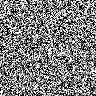

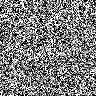

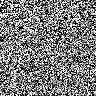

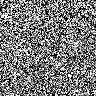

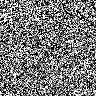

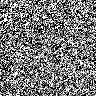

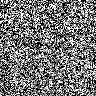

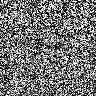

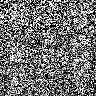

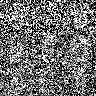

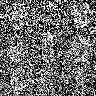

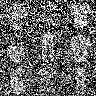

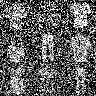

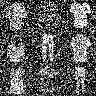

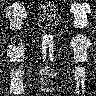

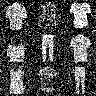

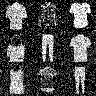

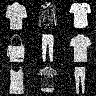

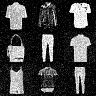

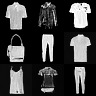

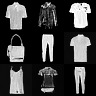

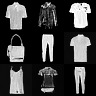

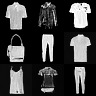

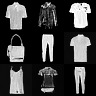

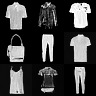

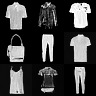

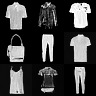

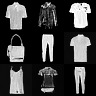

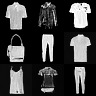

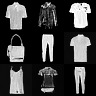

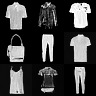

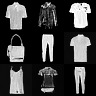

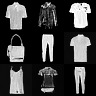

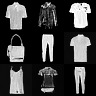

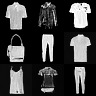

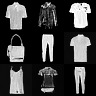

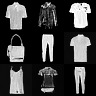

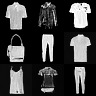

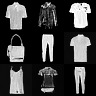

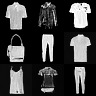

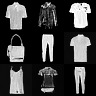

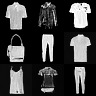

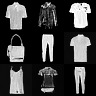

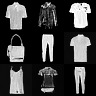

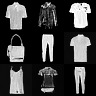

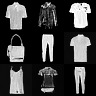

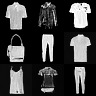

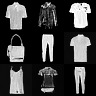

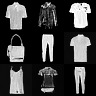

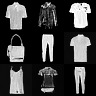

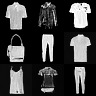

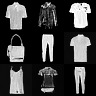

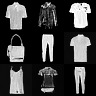

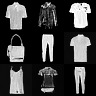

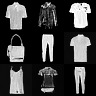

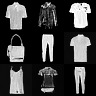

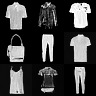

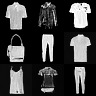

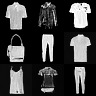

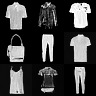

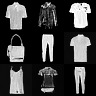

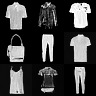

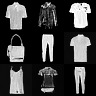

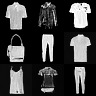

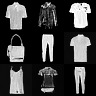

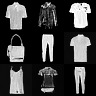

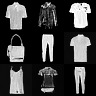

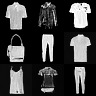

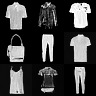

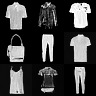

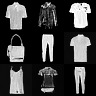

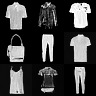

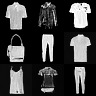

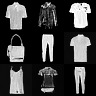

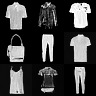

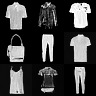

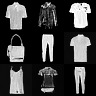

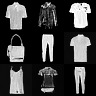

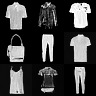

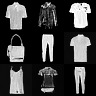

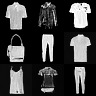

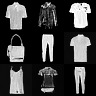

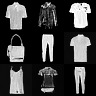

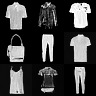

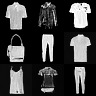

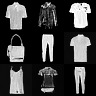

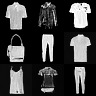

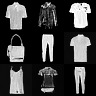

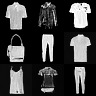

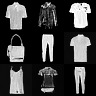

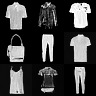

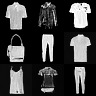

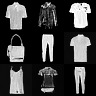

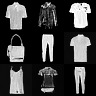

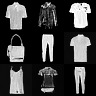

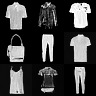

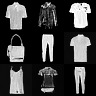

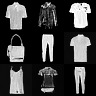

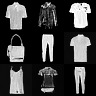

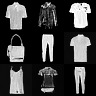

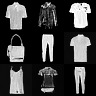

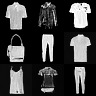

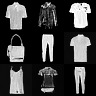

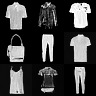

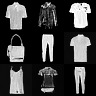

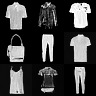

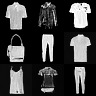

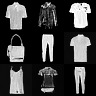

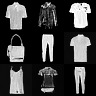

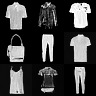

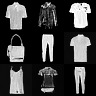

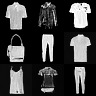

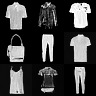

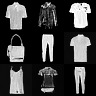

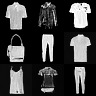

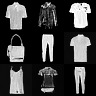

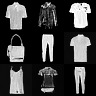

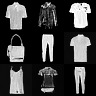

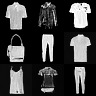

output:


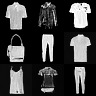

In [ ]:
from PIL import Image
from PIL import GifImagePlugin

imageObject = Image.open(f"/content/pred/pred.gif")
print(imageObject.n_frames)

# Display individual frames from the loaded animated GIF file
for frame in range(0,imageObject.n_frames):
    imageObject.seek(frame)
    imageObject.show()
print("output:")
imageObject.show()

FID SCORE :

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = g.mean(axis=0), cov(g, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

act1 = random(9*1024) #9 because 9 images are being generated and there are 1024 elements in each image
act1 = act1.reshape((9, 1024))

#gen_samples = (gen_samples * 255).type(torch.float32)
gen_samples = numpy.array((9, 1024))

g = gen_samples

# fid between act1 and act2
fid = calculate_fid(act1, g)
print('FID (different): %.3f' % fid)

FID (different): 800080207.893


In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

def scale_images(images, new_shape):

  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
(images1, _), (images2, _) = cifar10.load_data()
shuffle(images1)
images1 = images1[:10000]
print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

87910968/87910968 [==============================] - 1s 0us/step
Loaded (10000, 32, 32, 3) (10000, 32, 32, 3)


Clip Score

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial


def calculate_clip_score(images, prompts):
    images_int = transforms.ToTensor(images)
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

clip_score_fn = partial(clip_score, model_name_or_path="model")
prompts = "E"

sd_clip_score = calculate_clip_score(gen_samples[0], prompts)
print(f"CLIP score: {sd_clip_score}")

TypeError: ignored

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 22.1 MB/s eta 0:00:00


In [ ]:
import torchvision
import torchmetrics
from numpy.random import shuffle
from keras.datasets import cifar10

In [ ]:
from torchvision.transforms import functional as F

(images1, _), (images2, _) = cifar10.load_data()
shuffle(images1)
images1 = images1[:10000]
print('Loaded', images1.shape, images2.shape)

real_images = images1
fake_images = images2
print(real_images.shape)

170498071/170498071 [==============================] - 13s 0us/step
Loaded (10000, 32, 32, 3) (10000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
!pip install torch-fidelity
!pip install torchmetrics[image]

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(f"FID: {float(fid.compute())}")

ModuleNotFoundError: ignored

In [ ]:
!pip install pytorch-fid

In [ ]:
python -m pytorch_fid /mnt/d/Diffusion-Models-pytorch-main/landscape_dataset /mnt/d/Diffusion-Models-pytorch-main/landscape_dataset

SyntaxError: ignored

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.datasets.mnist import load_data
import torch.nn as nn

# wrapper class as feature_extractor
class WrapperInceptionV3(nn.Module):

    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3

    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

# use cpu rather than cuda to get comparable results
device = "cpu"

# pytorch_fid model
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

# wrapper model to pytorch_fid model
wrapper_model = WrapperInceptionV3(model)
wrapper_model.eval();

# comparable metric
pytorch_fid_metric = FID(num_features=dims, feature_extractor=wrapper_model)

SyntaxError: ignored

In [ ]:
metric = FID(num_features=1, feature_extractor=default_model)
metric.attach(default_evaluator, "fid")
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

NameError: ignored